# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
from pandas import json_normalize

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

from bs4 import BeautifulSoup
import unicodedata

import logging
import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate


TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
# ----------- NLP modules ----------- #

from transformers import pipeline

# Zero shot classification with Hugging Face Transformers
---

Recent Transformer language models allow for zero shot classification. We can pass arbitrary classification labels for inference that the model hasn't been trained on and get (hopefully) meaningful predictions. This opens up entirely novel and creative ways to enrich metadata for podcasts. In this notebook I'd like to explore this and assess the quality that we can expect. 



# Load and prepare data

- I start by loading the data, joining various text columns to a single feature and cleaning the data (remove HTML, links, very short tokens etc.).
- Most transformers models (and the one that we are using here) can only process sentences or short paragraphs of up to 512 tokens (which usually are subword tokens). To accomodate for that I only process the first 512 words of every podcast text document thereby omitting a lot of available information.


In [3]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")

# Remove all podcast that weren't updated after 2018.
df.releaseDate = pd.to_datetime(df.releaseDate)
to_drop = df[df.releaseDate.dt.year<2019].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(6636, 29)

In [4]:
def join_text_columns(data):
    text = []
    for row in data.values:
        if type(row) is str:
            text.append(row)
        elif isinstance(row, (np.ndarray, list)):
            text.append(" ".join(row))
        else:
            assert row is None
            text.append("")
            continue
    return " ".join(text)    

In [5]:
podcast_columns = ['artistName', 'title', 'subtitle', 'summary', "tags", 'ep_subtitles', 'ep_summaries', 'ep_contents']
df_pod = df[podcast_columns].apply(join_text_columns, axis=1) 

In [6]:
RE_ASCII = re.compile(r"[^A-Za-zÀ-žäüöÄÜÖ.!? ]", re.IGNORECASE)
REMOVE_LESS_THAN = 2

def clean_text(text, remove_name=False):
    
    # Reduce to 1000 words. We only need 512 tokens for Hugging Face models.
    text = " ".join(text.split(" ")[:1500])
    
    # Strip HTML tags.
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Normalize form of unicode strings.
    # https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
    # text = unicodedata.normalize("NFKD", text)
    
    # Keep only ASCII + European Chars and whitespace
    text = re.sub(RE_ASCII, " ", text)
   
    # Remove links.
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www.\S+', ' ', text)
    
    # Remove all words less than 2 digits long.
    text = " ".join([token for token in text.split(" ") if len(token)>REMOVE_LESS_THAN])
    
    if remove_name==True:
        # Remove persons names. 
        doc = nlp(text)
        text = [token.text for token in doc.ents if token.label_!="PER"]
        text = " ".join(text)
    
    return text

In [7]:
%%time
df_pod = df_pod.apply(clean_text)
df["text"] = df_pod

CPU times: user 9.54 s, sys: 454 ms, total: 9.99 s
Wall time: 9.99 s


In [8]:
# Reduce to 512 words to speed up processing.
# Again – we only need 512 tokens. 
df_pod = df_pod.apply(lambda x: " ".join(x.split(" ")[:512]))

In [9]:
df["text"] = df_pod
df["word_count"] = df.text.apply(lambda x: len(x.split()))

# Initial tests

For my tests I chose [this Hugging Face model](https://huggingface.co/Sahajtomar/German_Zeroshot) that has been trained on German language. 

- **The zero shot classification works by providing a hypotheses template with a placeholder (the curly brackets) and potential candidate labels.**
- **The model evaluates all labels in the template and scores each variant.** 
- The classification can be set as single or multi class (with argument `multi_label`). In case of `multi_label==False` all scores add up to 1. In case of `multi_label==True`, the probability of each label is scored individually. In this cases the score do not add up to 1, rather the score for each label can be as high as 1.
- From experiments **I observe that the quality of prediction very much relies on how the template sentence is worded.**
- For the moment I stick to the default of *«In diesem Text geht es um {}.»*
- **The classification seems to work much more precise with nouns** ("Lustiges") rather than adverbs/adjectives ("lustig").
- Inference takes substantial processing time (no GPU accelaration locally on my Mac). I tried inference on Colab with a K80 and found that this is around ~2 times faster. Zero shot classification with the Hugging Face models unfortunately doesn't allow for paralellization.

In [10]:
# classifier = pipeline("zero-shot-classification", model='Sahajtomar/German_Zeroshot')
# classifier.save_pretrained("_data/_huggingface/")
classifier = pipeline("zero-shot-classification", model="_data/_huggingface/")

Let's start with a sanity check. 
- A simple and serious news headline is properly classified.
- The classifier yields the labels (sorted by score!) and corresponding scores as well as the text sequence that was passed to it for inference.

In [113]:
# Using the default template from the model card.
template = "In diesem Text geht es um {}."
labels = ["Ernstes", "Lustiges"]
text = 'Ein Moskauer Gericht hat Bußgelder in Millionenhöhe gegen Google und Facebook verhängt.'
display(classifier(text, labels, hypothesis_template=template))

{'sequence': 'Ein Moskauer Gericht hat Bußgelder in Millionenhöhe gegen Google und Facebook verhängt.',
 'labels': ['Ernstes', 'Lustiges'],
 'scores': [0.8347563147544861, 0.1652437150478363]}

A text about something humorous is properly classified as well.

In [114]:
text = 'Das ist das Witzigste was ich je gesehen habe. Ich musste sehr lachen über diesen Gag.'
display(classifier(text, labels, hypothesis_template=template))

{'sequence': 'Das ist das Witzigste was ich je gesehen habe. Ich musste sehr lachen über diesen Gag.',
 'labels': ['Lustiges', 'Ernstes'],
 'scores': [0.9838461875915527, 0.01615379936993122]}

Podcast text samples from various genres work too.

In [117]:
text = df[df.primary_genre=="Comedy"].text.sample(1, random_state=42).values
result = classifier(text, ["Ernstes", "Lustiges"], hypothesis_template="In diesem Text geht es um {}.")
print(result["sequence"][:400])
print(result["labels"])
print(result["scores"])

Joel und Kian Der Podcast mit Joel und Kian. diesem Podcast begleiten wir euch ein wenig durch den Alltag und versuchen euch ein wenig Freude und Unterhaltung geben. Wir sind zwar nicht vergleichbar mit Podcast von Fest und Flauschig oder Gemischtes Hack aber dafür tragen wir auf unserem Coverbild ein Hemd. Also wenn nach Abschweifenden Gesprächen stumpfen Humor oder leichter Comedy suchst bist hi
['Lustiges', 'Ernstes']
[0.8244453072547913, 0.17555469274520874]


In [118]:
text = df[df.primary_genre=="Religion"].text.sample(1, random_state=42).values
result = classifier(text, ["Religion", "Wissenschaft"], hypothesis_template="In diesem Text geht es um {}.")
print(result["sequence"][:400])
print(result["labels"])
print(result["scores"])

Baptisten Leipzig Baptisten Leipzig Podcast der Baptisten Leipzig zur verschiedenen Themenreihen Podcast der Baptisten Leipzig zur verschiedenen Themenreihen religion religion spirituality Denkst dass gesegnet bist? Oder fallen Dir doch viele Dinge Deinem Leben ein die noch nicht gut laufen? Vielleicht ist das Studium der Job die Beziehung oder die Familie. Aber was wenn trotzdem annehmen würdest 
['Religion', 'Wissenschaft']
[0.8847039937973022, 0.11529601365327835]


In [119]:
text = df[df.primary_genre=="Wissenschaft"].text.sample(1, random_state=42).values
result = classifier(text, ["Religion", "Wissenschaft"], hypothesis_template="In diesem Text geht es um {}.")
print(result["sequence"][:400])
print(result["labels"])
print(result["scores"])

Michaela Voth Nachgefragt Der skeptische Talk Nachgefragt ist ein kostenloser Interview Podcast über Wissenschaftskommunikation skeptische Themen und Pseudowissenschaften. science Als Geek kräftig Gewicht verlieren mit Elkin Fricke sind sie dann ein bisschen größenwahnsinnig geworden mit Martin Sauter Dann kannst die Fäden des Universums selbst manipulieren mit Ulrike Schiesser Das Ding kann Feuer
['Wissenschaft', 'Religion']
[0.830094039440155, 0.16990599036216736]


# Classify on full data set, validate results

By creating scores for the candidate labels «Ernstes» vs. «Lustiges» and examining the result I can see that **zero shot classification works quite well on my data.** 

In [12]:
def get_zero_shot(data, labels, template):
    # The score for the first label is recorded. 
    # The higher the score value, the more the first label is true for the given text.
    results = []
    for text in tqdm(data):
        res = classifier(text, labels, hypothesis_template=template)
        res = dict(zip(res["labels"], res["scores"]))
        results.append(res[labels[0]])
    return results

In [13]:
results = get_zero_shot(df.text, 
                        ["Ernstes", "Lustiges"], 
                        "In diesem Text geht es um {}.")
df["serious_funny"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [215]:
top_n = 10
min_word_count = 200
cols = ["title", "text", "primary_genre", "serious_funny"]

with pd.option_context('display.max_colwidth', 80):
    display(df[df.word_count>=min_word_count].sort_values("serious_funny", ascending=False)[cols].head(top_n))
    display(df[df.word_count>=min_word_count].sort_values("serious_funny", ascending=False)[cols].tail(top_n))
print()

,title,text,primary_genre,serious_funny
5573,Um Himmels Willen,Sophie und Luca Himmels Willen Zwei Christen probieren das Chaos der Welt ve...,Christentum,0.993285
3888,Corona aktuell – der Podcast der Bundesregierung,Presse und Informationsamt der Bundesregierung Corona aktuell der Podcast de...,Regierung,0.987447
6462,Kemferts Klima-Podcast,Mitteldeutscher Rundfunk Kemferts Klima Podcast Wir besprechen aktuelle Stud...,Wissenschaft,0.985603
2679,Killed in Action - Deutschland im Krieg,NDR Info Killed Action Deutschland Krieg Tod Trauer Verwundung und Traumatis...,Politik,0.980832
5901,Film Ab! Podcast,FilmAb Podcast Film Ab! Podcast Benedikt von FilmAb! und Leo von TheFilmGuys...,TV und Film,0.980192
5560,Alles ok?,The forward Studios Alles ok? Ein Mental Health Podcast Heute dies morgen da...,Mentale Gesundheit,0.979822
5972,Unrecht im Polizeiapparat - Erfahrungen eines Ex-Insiders,Julian Unrecht Polizeiapparat Erfahrungen eines Insiders Kein System ist lüc...,Politik,0.978800
3481,abgründe. - True-Crime-Podcast von nordbayern.de,nordbayern.de Nürnberger Nachrichten abgründe. True Crime Podcast von nordba...,Wahre Kriminalfälle,0.978433
5699,Kind im Blick,Mitteldeutscher Rundfunk Kind Blick Gewalt gegen Kinder ist alltäglich. Aber...,Kinder und Familie,0.978364
3658,Leberkast,Dominik Türk Jonathan Miehlich Leberkast Von Ebola Epidemien bis zum Rohrbru...,Neues aus der Unterhaltung,0.977156


,title,text,primary_genre,serious_funny
4728,Gute Nacht mit der Maus,Westdeutscher Rundfunk Gute Nacht mit der Maus Nach einem aufregenden Tag is...,Geschichten für Kinder,0.023675
5797,Ingrid Kühne - Nur ma so...,Ingrid Kühne Ingrid Kühne Nur so... Tja gibt viel sagen was einfach nur mal ...,Comedy Interviews,0.022270
3150,TalkSchuh - Der Sneaker Podcast,Hikmet Sugoer John von JAM TalkSchuh Der Sneaker Podcast Mehr Infos mehr Ent...,Mode und Schönheit,0.021878
5178,That's What He Said,Donnie Sullivan Pool Artists That What Said Mit Donnie Sullivan Donnie Sulli...,Comedy,0.021719
4756,Kinderhörspiel - Das Detektivbüro Frederick (Der Kinder-Podcast mit Geschich...,Mario Frederick Kinderhörspiel Das Detektivbüro Frederick Der Kinder Podcast...,Geschichten für Kinder,0.021571
3468,"Dicke Senftube mit Paul, Max und Chrissi",Christopher Hein Max Schwenzer und Paul Sanguinette Dicke Senftube mit Paul ...,Comedy Interviews,0.020866
4958,DRINNIES,Giulia Becker Chris Sommer DRINNIES Zwei DRINNIES berichten aus der Komfortz...,Comedy,0.018323
2770,Aufgschnappt in Bayern,Claudia Pichler Aufgschnappt Bayern Podcast von Claudia Pichler Claudia Pich...,Neues aus der Unterhaltung,0.016177
4625,Comedy Deutschland,Ole Waschkau Brotdose Kunst Comedy Deutschland Der Podcast mit lustigen Mens...,Comedy Interviews,0.015977
1079,Sprachnachrichten - Gesprächsthemen für jede Lebenslage,Kevin Hennings Aron Dehghan Sprachnachrichten Gesprächsthemen für jede Leben...,Neues aus der Unterhaltung,0.015307


- **Aggregating the scores by primary genre confirms the validity of the classification.**
- Serious genres like true crime or government rank high, while funnier genres like comedy or kid's stories have low scores.

In [216]:
top_n = 80
top_genres = df.groupby("primary_genre").title.count().sort_values(ascending=False).head(top_n).index.tolist()
tmp = pd.DataFrame(df.groupby("primary_genre").serious_funny.median().loc[top_genres].sort_values(ascending=False))
print("Zero shot scoring for «Ernst» vs «Lustig»")
print(tabulate(tmp, floatfmt=".2f"))

Zero shot scoring for «Ernst» vs «Lustig»
--------------------------  ----
Wahre Kriminalfälle         0.79
Regierung                   0.77
Christentum                 0.76
Sozialwissenschaften        0.74
Politik                     0.73
Religion und Spiritualität  0.72
Wirtschaftsnachrichten      0.70
Medizin                     0.70
Religion                    0.68
Natur                       0.68
Nachrichten                 0.67
Nachrichten des Tages       0.66
Drama                       0.66
Geldanlage                  0.66
Dokumentation               0.65
Gemeinnützig                0.64
Wissenschaft                0.64
Kurse                       0.64
Fitness                     0.64
Ernährung                   0.64
Management                  0.63
Marketing                   0.62
Gesundheit und Fitness      0.62
Wirtschaft                  0.62
Mentale Gesundheit          0.62
Spiritualität               0.62
Naturwissenschaften         0.60
Alternative Therapien       0.60
B

# Evaluate more candidate labels

I sample a representative subset of the podcast data to speed up processing and try out various other candidate labels.

In [217]:
df_sub = df[df.chartable_genre.notna()].groupby("chartable_genre").sample(20, random_state=42)
print(f"Sampled a subset of {df_sub.shape[0]} podcasts from charts of various genres.")

Sampled a subset of 380 podcasts from charts of various genres.


In [14]:
%%time
results = get_zero_shot(df.text, 
                        ["Wissenschaft", "Spiritualität"], 
                        "In diesem Text geht es um {}.")
df["science_spirituality"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

CPU times: user 6h 39min 44s, sys: 42min 55s, total: 7h 22min 40s
Wall time: 2h 33min 33s


The antithetical labels of «science» vs «spirituality» work well too. The resulting ranking makes senses.

In [205]:
cols = ["title", "text", "primary_genre", "science_spirituality"]
with pd.option_context('display.max_colwidth', 100):
    display(df_sub[df_sub.word_count>=min_word_count].sort_values("science_spirituality", ascending=False)[cols].head(10))
    display(df_sub[df_sub.word_count>=min_word_count].sort_values("science_spirituality", ascending=False)[cols].tail(10))

,title,text,primary_genre,science_spirituality
6286,Das Impfbuch für alle – Das Hörbuch,Robert Koch Institut Bundeszentrale für gesundheitliche Aufklärung Bundesministerium für Gesundh...,Wissenschaft,0.944147
4271,Bugtales.fm - Die Abenteuer der Campbell-Ritter,Bugtales.FM Bugtales.fm Die Abenteuer der Campbell Ritter Wieso werden die Arme von Kraken einze...,Natur,0.942095
5816,Künstliche Intelligenz,Peter Buxmann Holger Schmidt Künstliche Intelligenz Der Podcast über Künstliche Intelligenz Podc...,Management,0.936388
3757,Kekulés Corona-Kompass von MDR AKTUELL,Mitteldeutscher Rundfunk Kekulés Corona Kompass von MDR AKTUELL Prof. Alexander Kekulé erklärt P...,Nachrichten,0.920370
5506,"DIE IDEE. Ideen, Leute, Stories.",NDR DIE IDEE. Ideen Leute Stories. Der Podcast für alle die sich für Ideen und die Menschen dahi...,Gesellschaft und Kultur,0.907051
3742,FAZ Wissen,Frankfurter Allgemeine Zeitung FAZ FAZ Wissen Der Wissenspodcast der Frankfurter Allgemeinen Zei...,Naturwissenschaften,0.905241
6352,AuA-Podcast,Arbeit und Arbeitsrecht AuA Podcast Der Arbeitsrechtspodcast Das ist der neue Podcast von Arbeit...,Wissenschaft,0.894735
4345,Der Springer Medizin Podcast,Redaktion SpringerMedizin.de Der Springer Medizin Podcast Medizin für Gesundheitsprofis Der Spri...,Medizin,0.879735
1690,Steingarts Morning Briefing – Der Podcast,Gabor Steingart Steingarts Morning Briefing Der Podcast Das Morning Briefing von Gabor Steingart...,Nachrichten,0.859872
6385,Siege der Medizin | Der medizinhistorische Podcast,Apotheken Umschau Gesundheit hören.de Siege der Medizin Der medizinhistorische Podcast Dieser Po...,Gesundheit und Fitness,0.857322


,title,text,primary_genre,science_spirituality
6495,"Der uDiscover-Podcast – Stories, Rock & Popkultur",Universal Music Podcasts uDiscover Music Christof Leim Tobi Wienke Der uDiscover Podcast Stories...,Musikgeschichte,0.098976
5623,Paranormal hautnah,Carina Anna und Julia Paranormal hautnah Paranormal hautnah ist ein Podcast bei dem wir über Spu...,Spiritualität,0.095839
3941,Tägliche Andacht von Joyce Meyer,Joyce Meyer Deutschland Tägliche Andacht von Joyce Meyer Brauchst Kraft für deinen Alltag? Lass ...,Spiritualität,0.093120
6255,OUR HOUSE - Der SALON Podcast,SALON OUR HOUSE Der SALON Podcast OUR HOUSE dem Podcast des SALON Magazins sprechen Anne Peterse...,Heim und Garten,0.082905
6436,Wenn das ich wäre - der BAYERN 3 Podcast über wilde und wahre Geschichten,Bayerischer Rundfunk Wenn das ich wäre der BAYERN Podcast über wilde und wahre Geschichten Jacqu...,Comedy,0.082372
6630,Reconnect,Jackie Freitag Reconnect Jackie Freitag Podcast Beschreibung Reconnect ist der Podcast der dich ...,Spiritualität,0.055157
6191,Channeling Kongress | Botschaften aus der Geistigen Welt,Channeling Kongress Channeling Kongress Botschaften aus der Geistigen Welt Schön dass den Weg zu...,Spiritualität,0.053349
4674,Raum für Bewusstsein - Podcast mit einem Lichtwesen,Christiane Hansmann Raum für Bewusstsein Podcast mit einem Lichtwesen Das Lichtwesen Salvador lä...,Spiritualität,0.048245
6295,advent-online Impulse in der Adventszeit,Eine Kooperation der vier Kirchen Baden Württemberg Erzbistum Freiburg Evangelische Landeskirche...,Christentum,0.035389
6593,Ist das Leben nicht schön? - Der UK Adventskalender,Unsere Kirche die Zeitung mit der guten Nachricht Ist das Leben nicht schön? Der Adventskalender...,Spiritualität,0.033865


Let's generate scorings for other pairs of candidate labels, now using the full data set again.

In [15]:
results = get_zero_shot(df.text, 
                        ["Männer", "Frauen"], 
                        "In diesem Text geht es um {}.")
df["men_women"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [16]:
results = get_zero_shot(df.text, 
                        ["Maskulines", "Feminines"], 
                        "In diesem Text geht es um {}.")
df["maskulin_feminin"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [17]:
results = get_zero_shot(df.text, 
                        ["Erwachsene und Rentner", "Kinder und Jugendliche"], 
                        "Dieser Text ist etwas für {}.")
df["adult_kid"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [18]:
results = get_zero_shot(df.text, 
                        ["Rationales", "Emotionales"], 
                        "In diesem Text geht es um {}.")
df["rational_emotional"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [23]:
%%time
results = get_zero_shot(df.text, 
                        ["das Individuum", "die Gesellschaft"], 
                        "In diesem Text geht es um {}.")
df["individuum_society"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

CPU times: user 6h 38min 27s, sys: 37min 46s, total: 7h 16min 13s
Wall time: 2h 29min 42s


In [24]:
results = get_zero_shot(df.text, 
                        ["Macht", "Ohnmacht"], 
                        "In diesem Text geht es um {}.")
df["power_powerless"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [25]:
results = get_zero_shot(df.text, 
                        ["Kurzfristiges", "Langfristiges"], 
                        "In diesem Text geht es um {}.")
df["shortterm_longterm"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [26]:
results = get_zero_shot(df.text, 
                        ["Genuss", "Beherrschung"], 
                        "In diesem Text geht es um {}.")
df["pleasure_restraint"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [27]:
results = get_zero_shot(df.text, 
                        ["Sicherheit", "Unsicherheit"], 
                        "In diesem Text geht es um {}.")
df["security_insecurity"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [28]:
results = get_zero_shot(df.text, 
                        ["Altes", "Neues"], 
                        "In diesem Text geht es um {}.")
df["old_new"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [29]:
results = get_zero_shot(df.text, 
                        ["Einfaches", "Komplexes"], 
                        "In diesem Text geht es um {}.")
df["simple_complex"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [32]:
results = get_zero_shot(df.text, 
                        ["Persönliches", "Allgemeines"], 
                        "In diesem Text geht es um {}.")
df["personal_general"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [33]:
results = get_zero_shot(df.text, 
                        ["Konkretes", "Abstraktes"], 
                        "In diesem Text geht es um {}.")
df["concrete_abstract"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [34]:
results = get_zero_shot(df.text, 
                        ["Geschichten", "Fakten"], 
                        "In diesem Text geht es um {}.")
df["stories_facts"] = results

  0%|          | 0/6636 [00:00<?, ?it/s]

In [36]:
df.to_parquet("_data/zeroshot_1228_full_data.parq")

# Visualize zero shot classification scores

In [5]:
df = pd.read_parquet("_data/zeroshot_1228_full_data.parq")

In [33]:
zero_shot_cols = ['serious_funny', 'science_spirituality', 'men_women', 'maskulin_feminin', 
                  'adult_kid', 'rational_emotional', 'individuum_society', 'power_powerless',
                  'shortterm_longterm', 'pleasure_restraint', 'security_insecurity',
                  'old_new', 'simple_complex', 'personal_general', 'concrete_abstract',
                  'stories_facts']

As a quick examination of the zero shot labeling I boxplot the score values of the various candidate label combinations. 
- **I observe quite different distributions. Some scorings are more widespread, e.g., `serious_funny`, others are very narrow, e.g. `adult_kid`.**
- I assume that **a narrow distribution around the mid value 0.5 might suggest that the model has a hard time deciding clearly for one or the other label**. We might need to work on the label definition to retrieve more unambiguous results.
- A narrow distribution with most values close to 0 or 1 might mean, that all samples tend towards this label (making the classification less meaningful). Or it might be that the other label is too «weak» in comparison to the other and by that not a suitable *antagonist* for a proper zero shot classification.
- **We also have to keep in mind that our use of this form of classification is experimental.** In regard to our data we do not really have a way of measuring precisely how accurate the classification is. We also have to acknowledge that the model brings in – basically unknown – biases from its training data, e.g. for candidate labels like `men_women`, `maskulin_feminin`. 
- The data that we assess here also is not neutral in any way but rather the more or less promotional information that the podcast creator submitted.

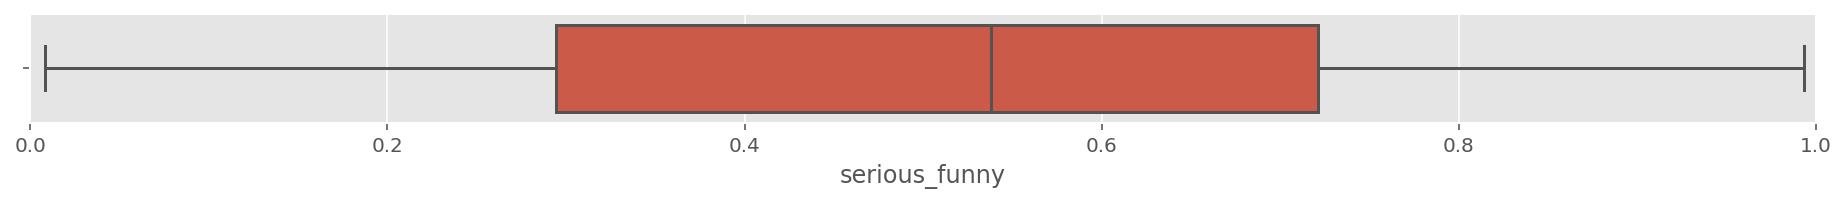

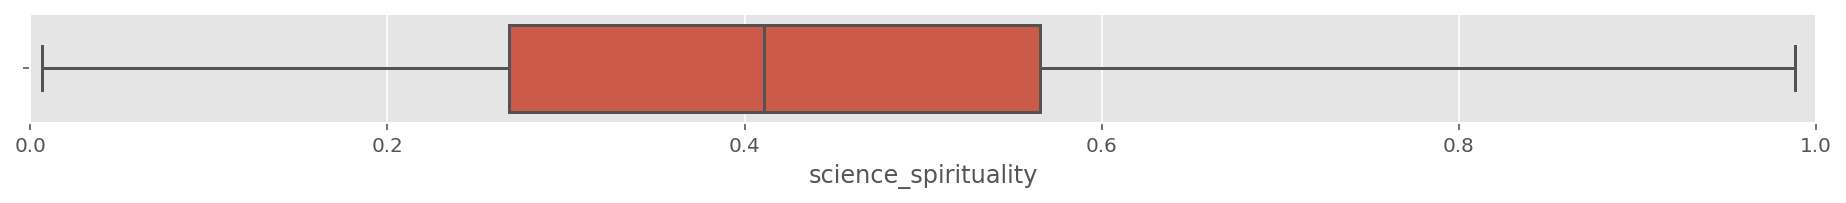

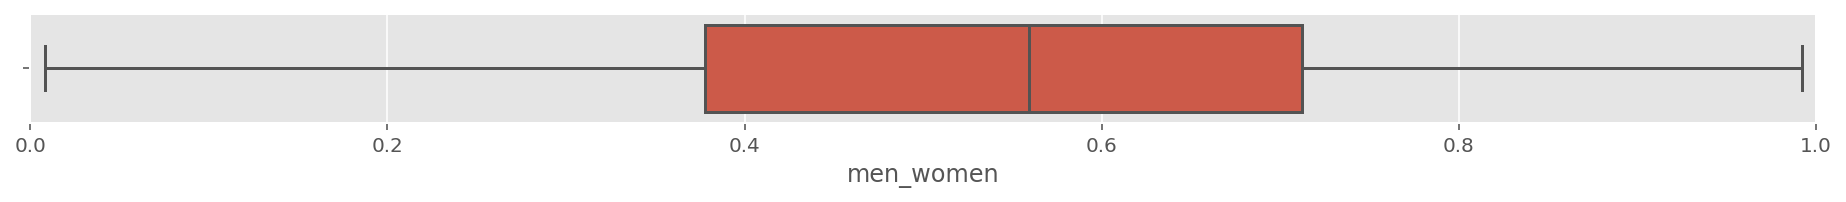

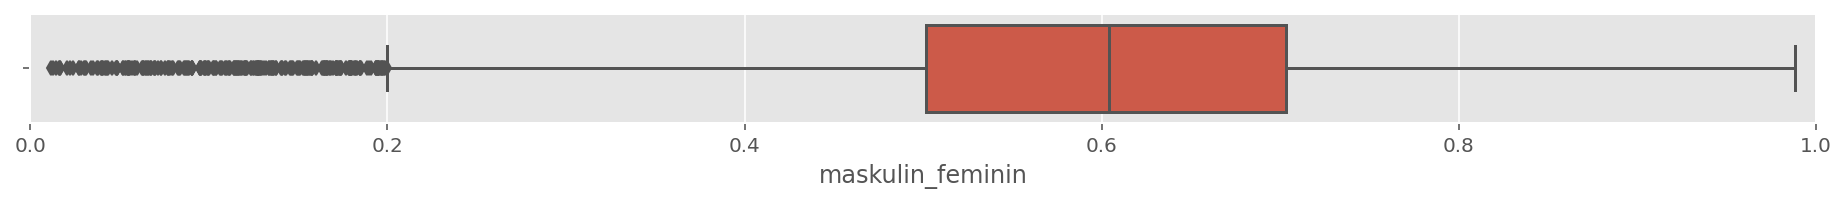

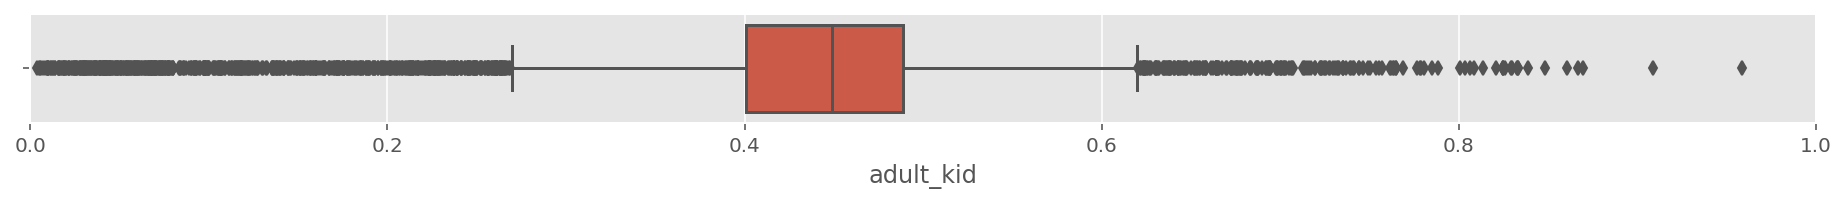

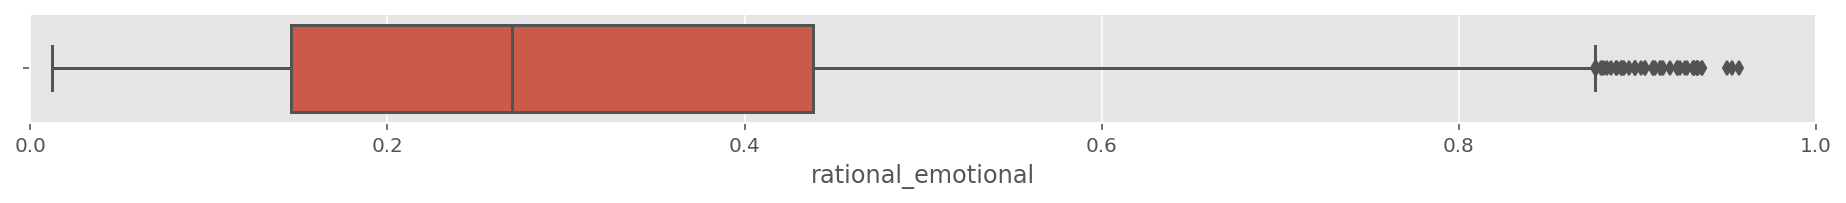

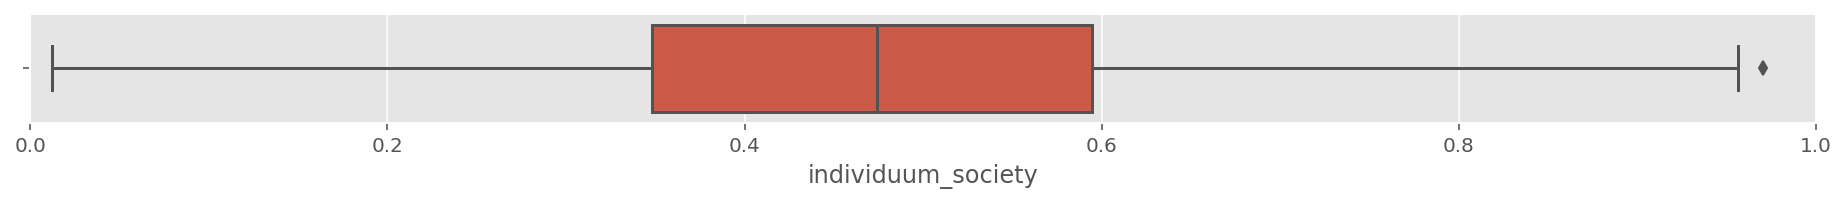

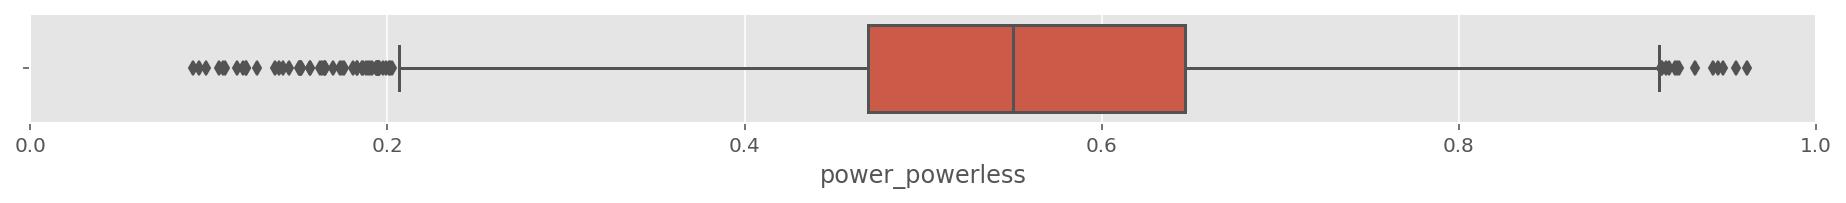

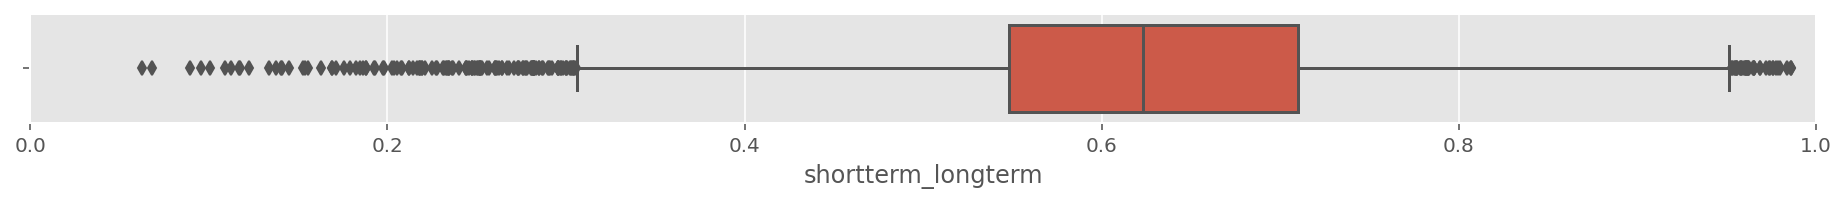

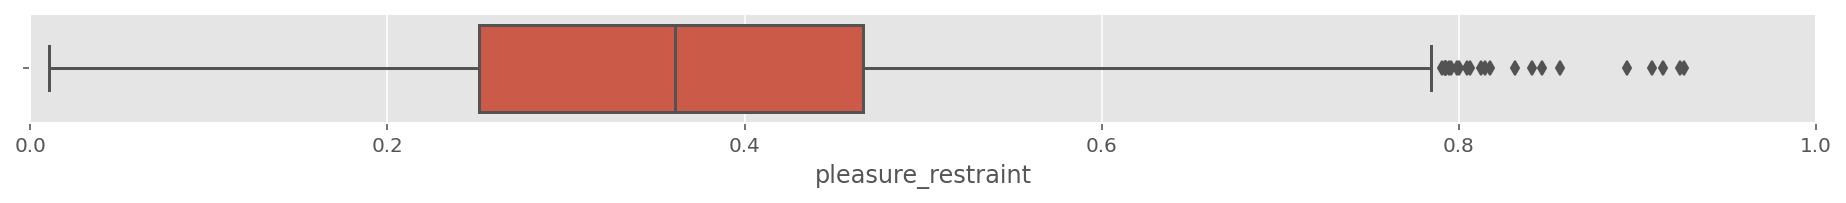

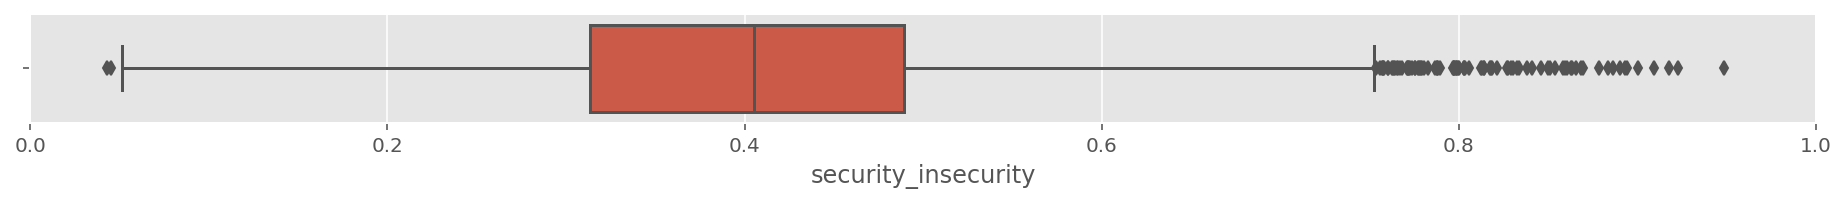

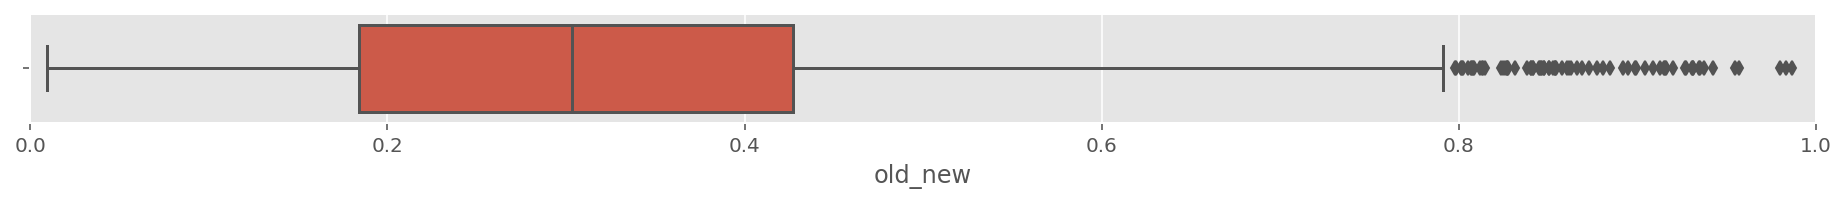

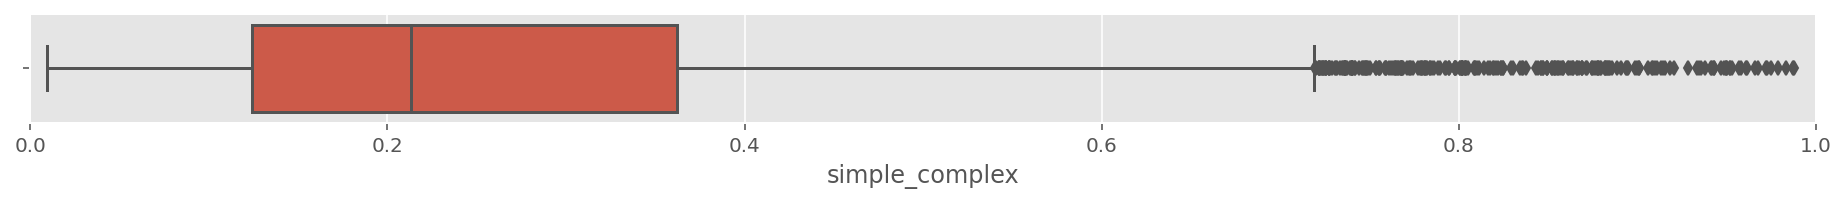

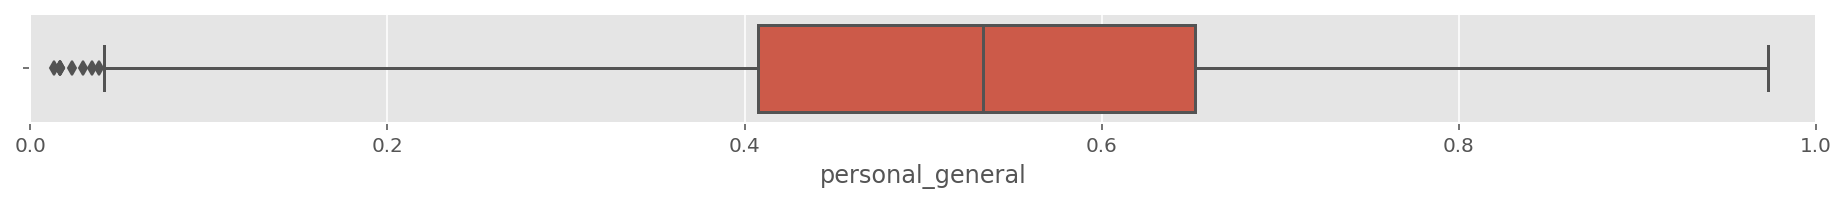

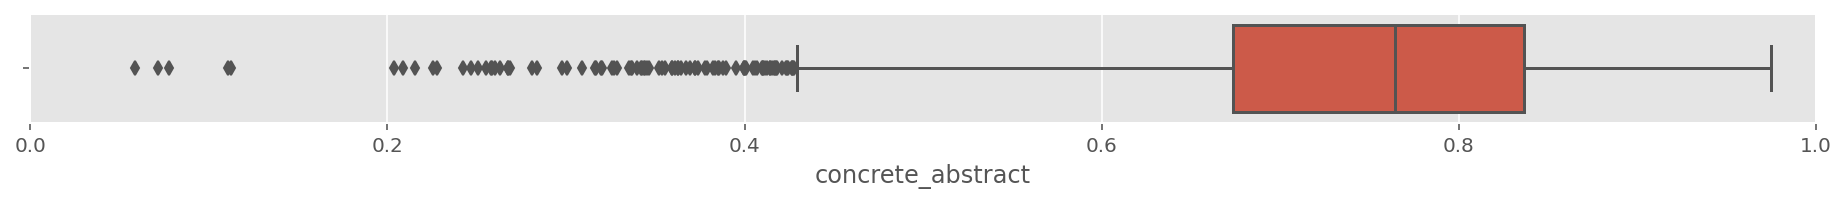

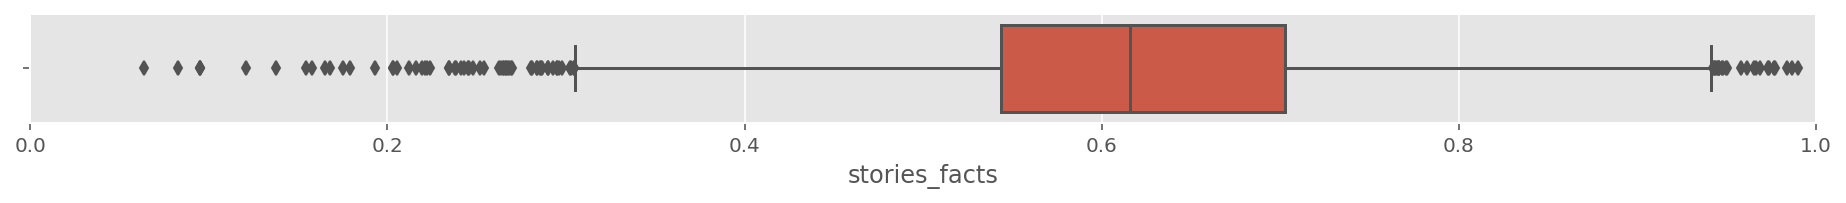

In [43]:
for col in zero_shot_cols:
    fig, ax = plt.subplots(figsize=(16,1))
    sns.boxplot(df[col], ax=ax)
    # sns.stripplot(df[col], ax=ax, size=1, color="green")
    plt.xlim(0,1)
    plt.show()

In [44]:
def create_graph(x_feat, y_feat):
    tmp = df.groupby("chartable_genre")[[x_feat, y_feat]].mean().reset_index()
    fig = px.scatter(data_frame=tmp, x=x_feat, y=y_feat, 
                     width=1200, height=800,
                     title=f'Zero Shot Classification – {x_feat.split("_")[0]} vs. {x_feat.split("_")[1]} / {y_feat.split("_")[0]} vs. {y_feat.split("_")[1]}',
                     text="chartable_genre", 
                     labels={"title": "Title",
                            "artistName": "Creator",
                            x_feat: f'<--- {x_feat.split("_")[1]} vs. {x_feat.split("_")[0]} --->',
                            y_feat: f'<--- {y_feat.split("_")[1]} vs. {y_feat.split("_")[0]} --->',
                            }, 
                    )
    fig.update_traces(textposition='top center', textfont_size=16)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

- **Scatterplotting several combinations of classifications reveals that the model yields sensible results in many cases (but not all).**
- E.g., the classification of funny vs. serious content and spirituality vs. science is more or less evenly spread around the midpoint and makes intuitive sense for most of the genres.

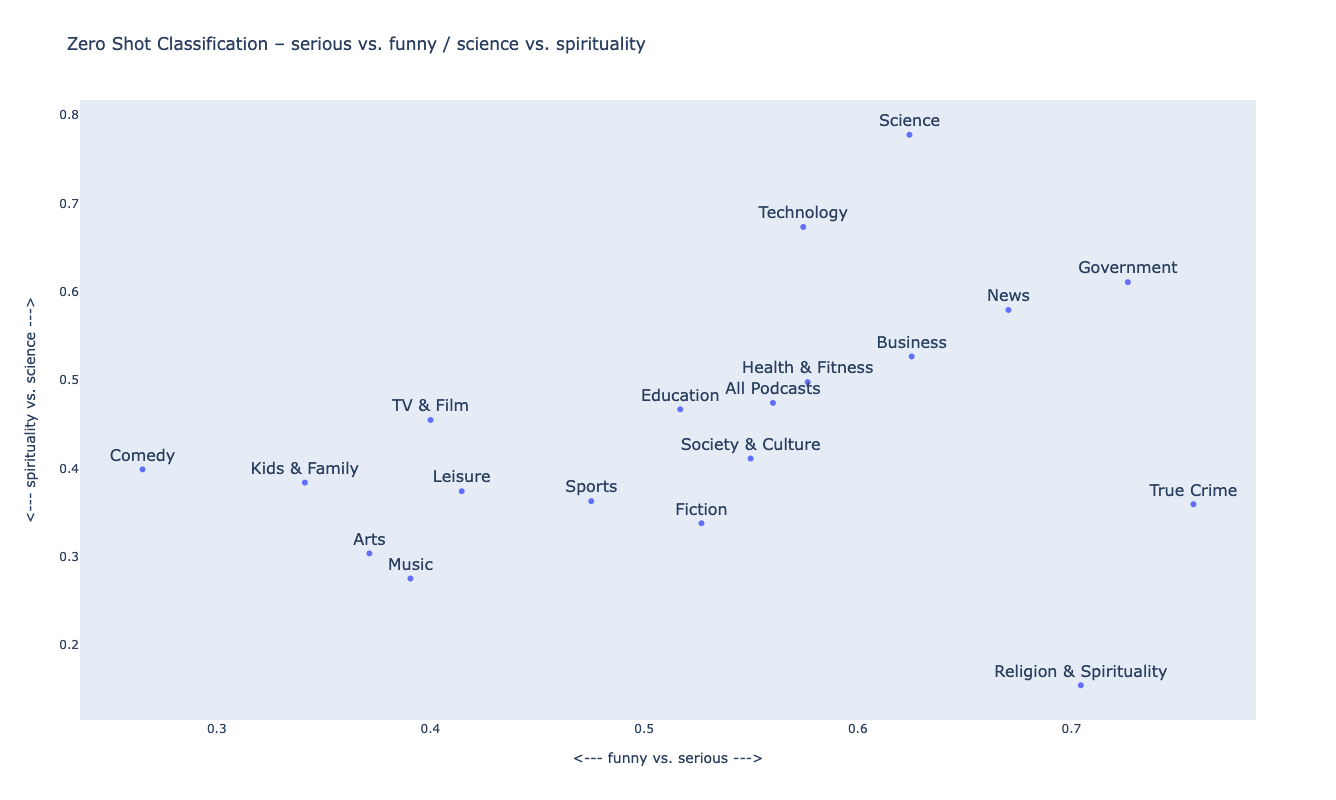

In [45]:
create_graph("serious_funny", "science_spirituality")

- The scores for men/women and adult/kid are skewed to one side of the midpoint. 
- With candidate label combinations like men/women or maskulin/feminin we are deep in clichee territory. We now face biases and imbalances that are embedded in language and training data.

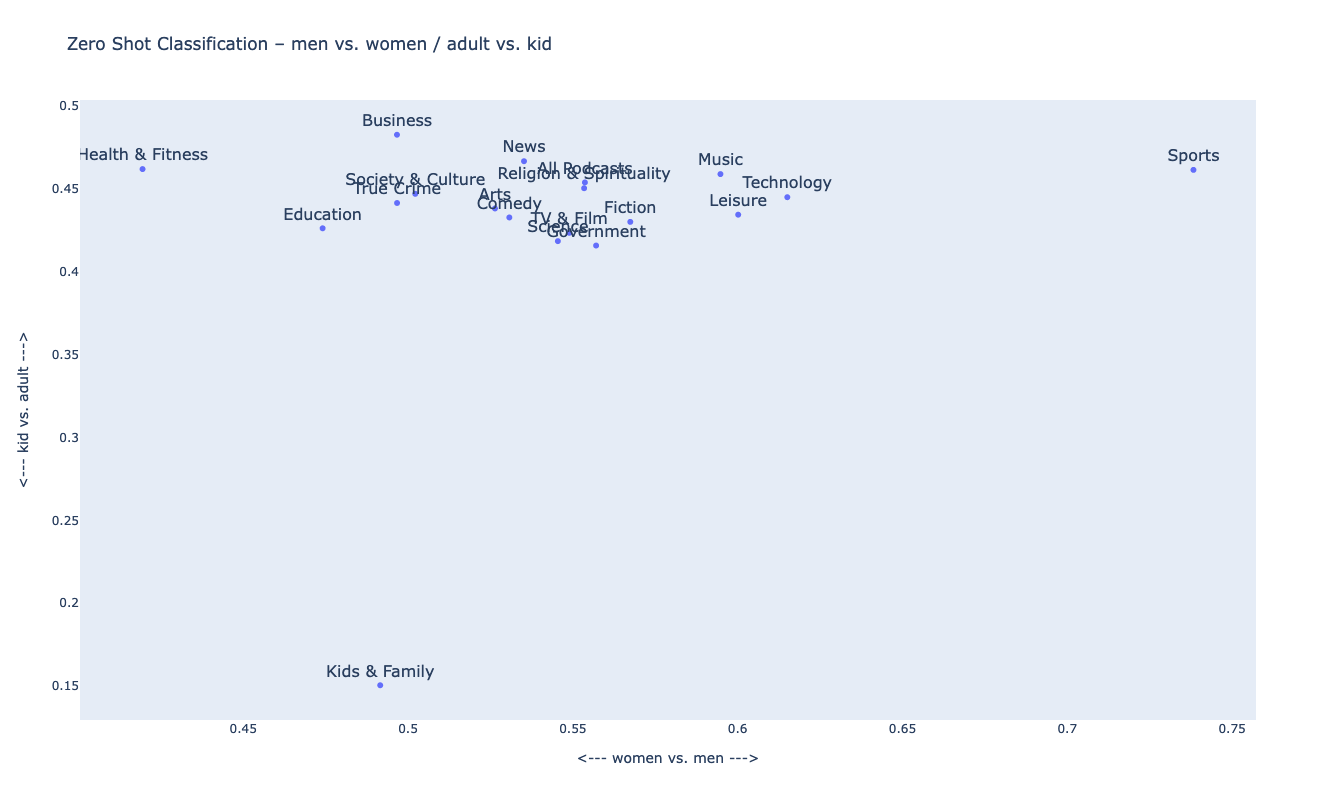

In [46]:
create_graph("men_women", "adult_kid")

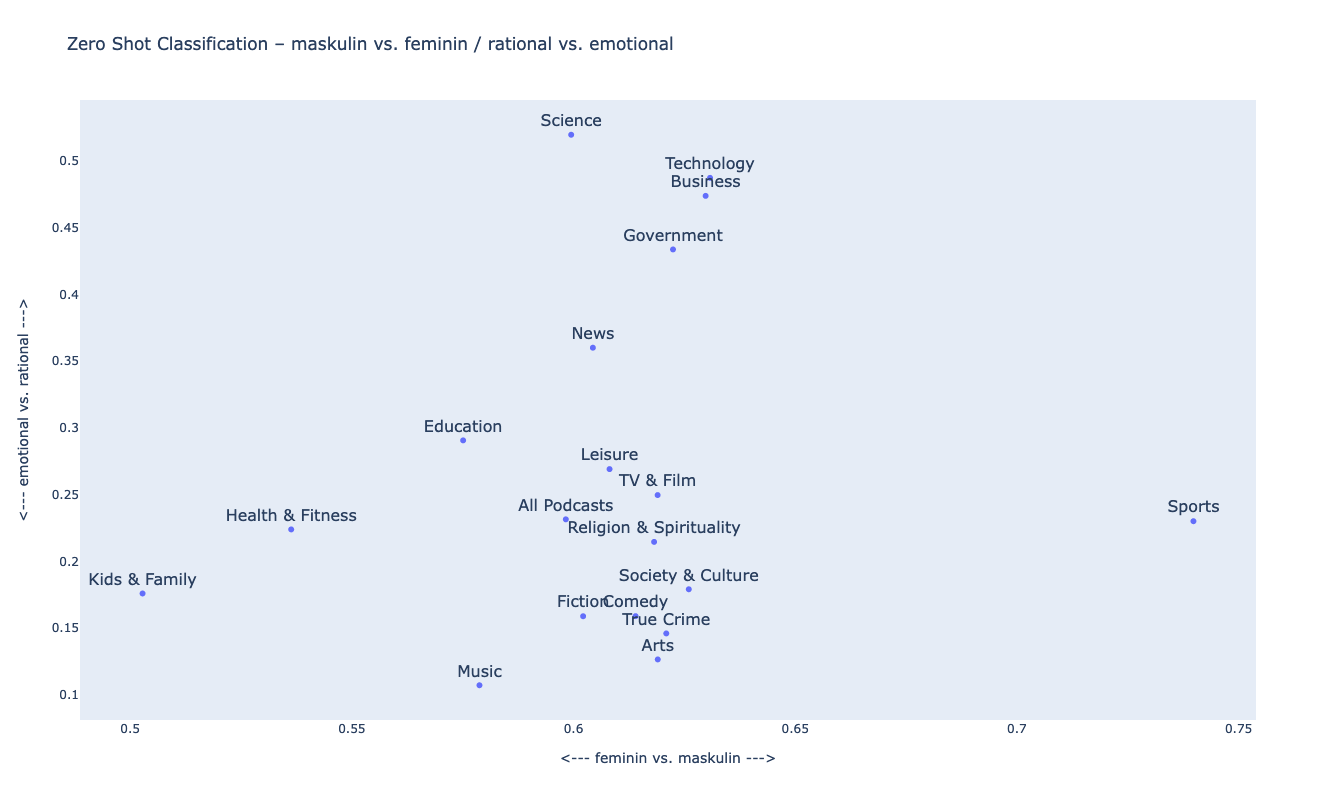

In [22]:
create_graph("maskulin_feminin", "rational_emotional")

It's interesting to see that even more creative and abstract labels like individual/society, shortterm/longterm, pleasure/restraint or personal/general work surprisingly well.

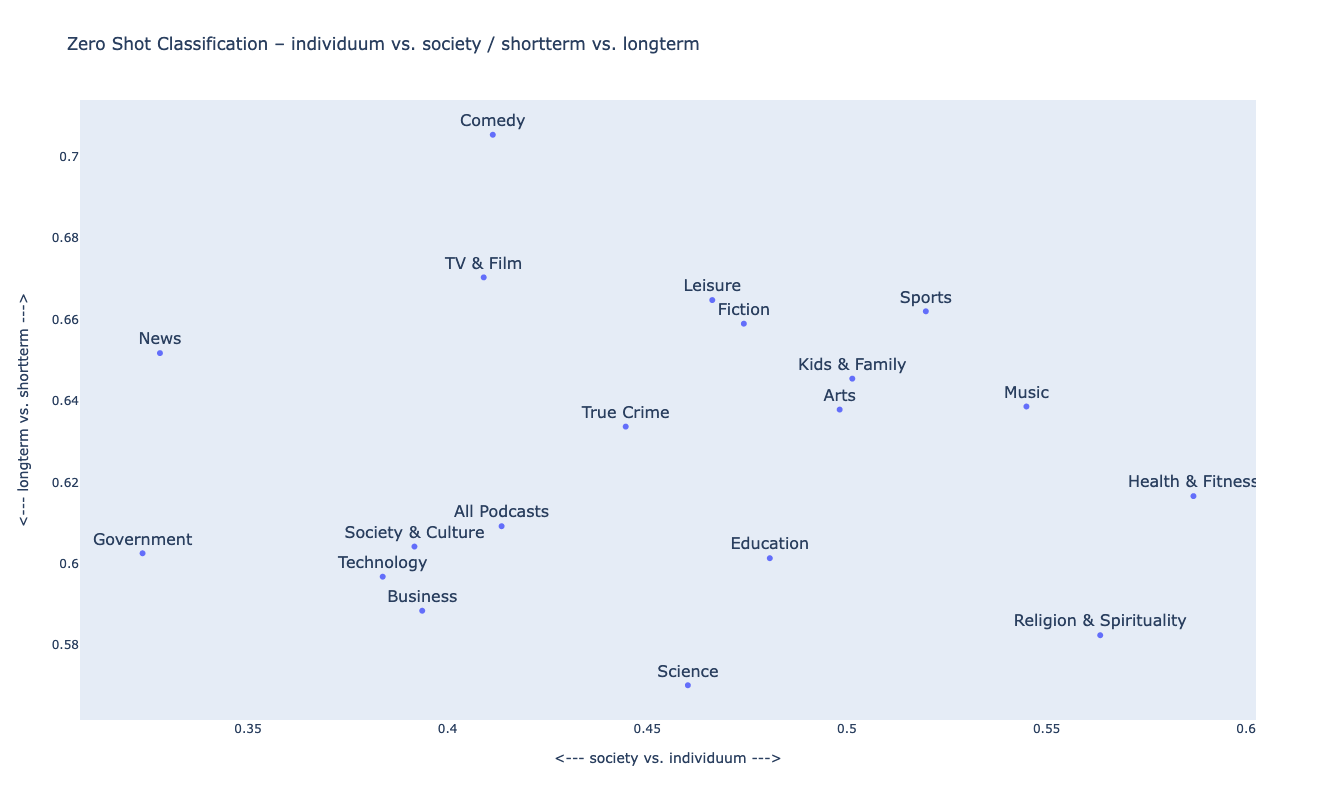

In [23]:
create_graph("individuum_society", "shortterm_longterm")

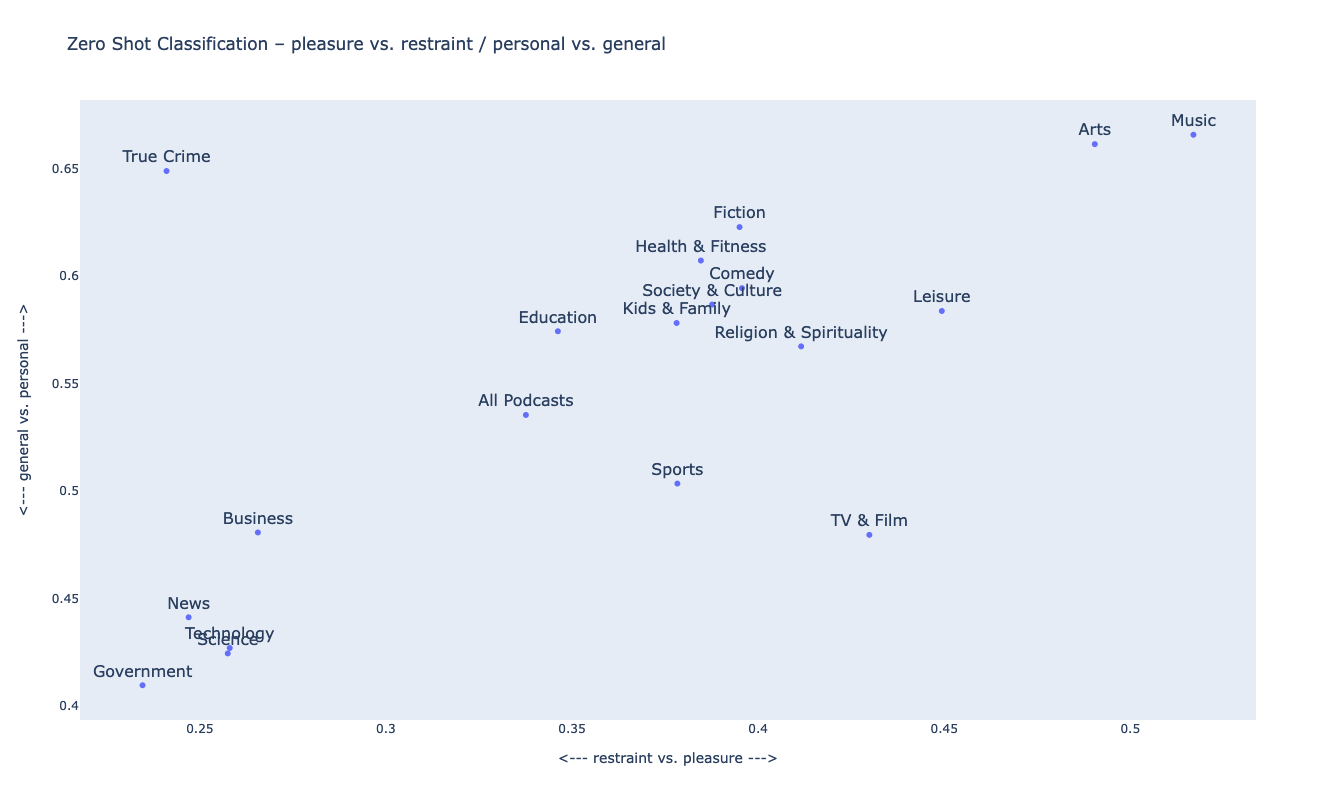

In [24]:
create_graph("pleasure_restraint", "personal_general")

Simple pairs like simple/complex, old/new work yield meaningful results too.

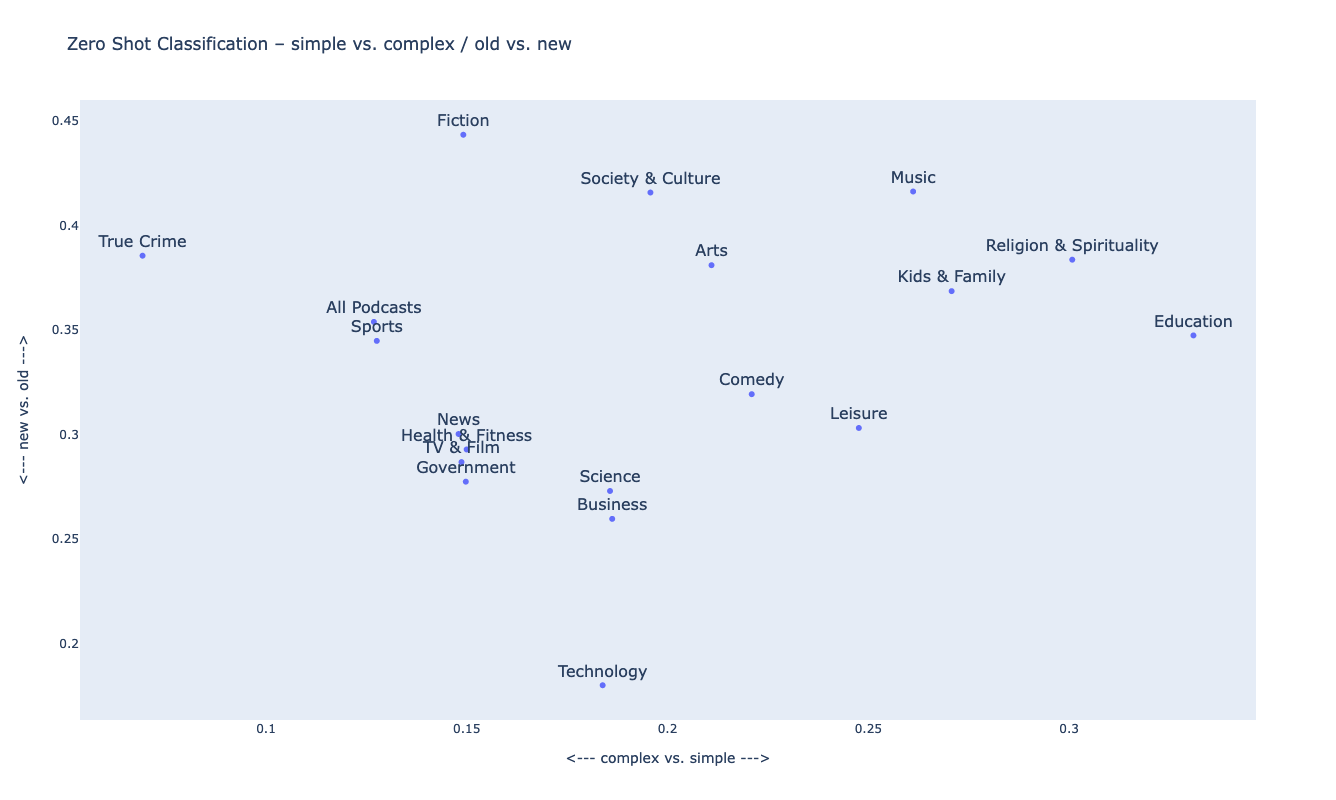

In [25]:
create_graph("simple_complex", "old_new")

I observe comprehensible results for pairs like concrete/abstract, stories/facts as well.

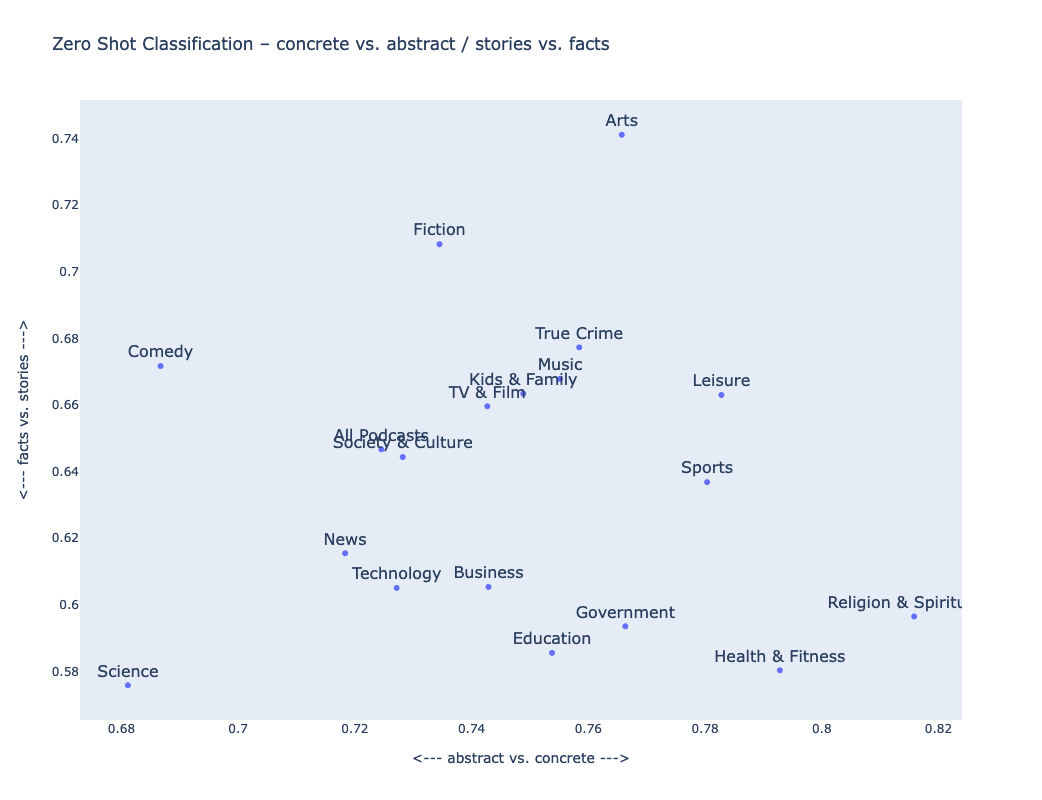

In [27]:
create_graph("concrete_abstract", "stories_facts")

# Conclusions

- **Zero shot classifications with Transformer models open up very interesting and – at least from my perspective – entirely new ways of generating meaningful meta data.**
- **I perceive the results as promising and assume that we could use these to enhance search and discovery of audio content substantially.**
- Inference takes ~2.5 hour per candidate label combination for the full data set. Though this is not super fast, we only would have to do it once for the whole corpus and could update the scorings when new episodes are published or entirely new podcasts are created. Inference could be sped up significantly with a performant GPU too.